In [1]:
import numpy as np
import torch
import torchvision
import os
import cv2
import torch.nn as nn
from torchsummary import summary
import pandas as pd
import matplotlib.pyplot as plt
import collections
from PIL import Image
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
# 1.모델구현
class Unet(nn.Module):
  def __init__(self):
    super().__init__()
    self.ConPathLayer1 = nn.Sequential(
        # torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(1,3), stride=1, padding=(25,0), padding_mode='reflect', dilation=(1,67)),
        torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
        torch.nn.ReLU()
    )

    self.MaxPool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

    self.ConPathLayer2 = nn.Sequential(
        torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1),
        torch.nn.ReLU()
    )

    self.MaxPool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

    self.ConPathLayer3 = nn.Sequential(
        torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1),
        torch.nn.ReLU()
    )

    self.MaxPool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

    self.ConPathLayer4 = nn.Sequential(
        torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1),
        torch.nn.ReLU()
    )

    self.MaxPool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

    self.BottomLayer = nn.Sequential(
        torch.nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1),
        torch.nn.ReLU()
    )

    self.UpConv1 = torch.nn.ConvTranspose2d(in_channels=1024, out_channels=512,kernel_size=2 , stride=2 )

    self.ExpPathLayer1 = nn.Sequential(
        torch.nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, stride=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1),
        torch.nn.ReLU()
    )

    self.UpConv2 = torch.nn.ConvTranspose2d(in_channels=512, out_channels=256,kernel_size=2 , stride=2 )

    self.ExpPathLayer2 = nn.Sequential(
        torch.nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1),
        torch.nn.ReLU()
    )

    self.UpConv3 = torch.nn.ConvTranspose2d(in_channels=256, out_channels=128,kernel_size=2 , stride=2 )

    self.ExpPathLayer3 = nn.Sequential(
        torch.nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1),
        torch.nn.ReLU()
    )

    self.UpConv4 = torch.nn.ConvTranspose2d(in_channels=128, out_channels=64,kernel_size=2 , stride=2 )

    self.ExpPathLayer4 = nn.Sequential(
        torch.nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=64, out_channels=2, kernel_size=1, stride=1)
        # torch.nn.Conv2d(in_channels=64, out_channels=2, kernel_size=(1,1), stride=1, padding=(66,158), padding_mode='replicate', dilation=(1,1))
    )

  def forward(self, x):
    x = self.ConPathLayer1(x)
    skip1 = torchvision.transforms.CenterCrop(392)(x)
    x = self.MaxPool1(x)
    x = self.ConPathLayer2(x)
    skip2 = torchvision.transforms.CenterCrop(200)(x)
    x = self.MaxPool2(x)
    x = self.ConPathLayer3(x)
    skip3 = torchvision.transforms.CenterCrop(104)(x)
    x = self.MaxPool3(x)
    x = self.ConPathLayer4(x)
    skip4 = torchvision.transforms.CenterCrop(56)(x)
    x = self.MaxPool4(x)
    # print("skip1:{}, skip2:{}, skip3:{}, skip4:{}".format(skip1.shape, skip2.shape, skip3.shape, skip4.shape))
    x = self.BottomLayer(x)
    x = self.UpConv1(x)
    x = torch.cat((skip4, x), dim=1)
    x = self.ExpPathLayer1(x)
    x = self.UpConv2(x)
    x = torch.cat((skip3, x), dim=1)
    x = self.ExpPathLayer2(x)
    x = self.UpConv3(x)
    x = torch.cat((skip2, x), dim=1)
    x = self.ExpPathLayer3(x)
    x = self.UpConv4(x)
    x = torch.cat((skip1, x), dim=1)
    result = self.ExpPathLayer4(x)

    return result



In [3]:
model_path_1050 = "/home/inbic/Desktop/SartoriusCellProj/models_1050_square/model_00.pth"
model_path_cpu = "C:/Users/syb62/Desktop/Unet/models_cpu/model_09.pth"
test_img_path = "C:/Users/syb62/Desktop/Unet/test/7ae19de7bc2a.png"
test_img_path_gpu = "/home/inbic/Desktop/SartoriusCellProj/test/7ae19de7bc2a.png"

In [4]:
def load_model(ckpt_path, device):
    checkpoint = torch.load(ckpt_path, map_location=device)
    model = Unet()
    model.load_state_dict(checkpoint)
    model = model.to(device)
    model.eval()
    return model

In [5]:
DEVICE = torch.device('cuda')
model = load_model(model_path_1050, DEVICE)

In [8]:
test_image = cv2.imread(test_img_path_gpu)
# cv2.imshow("test_image", test_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# print(test_image, test_image.shape)

In [9]:
print(test_image, test_image.shape)

[[[128 128 128]
  [128 128 128]
  [127 127 127]
  ...
  [127 127 127]
  [126 126 126]
  [125 125 125]]

 [[128 128 128]
  [128 128 128]
  [126 126 126]
  ...
  [128 128 128]
  [128 128 128]
  [128 128 128]]

 [[130 130 130]
  [130 130 130]
  [128 128 128]
  ...
  [131 131 131]
  [128 128 128]
  [131 131 131]]

 ...

 [[127 127 127]
  [127 127 127]
  [127 127 127]
  ...
  [136 136 136]
  [133 133 133]
  [132 132 132]]

 [[130 130 130]
  [130 130 130]
  [130 130 130]
  ...
  [137 137 137]
  [139 139 139]
  [137 137 137]]

 [[126 126 126]
  [129 129 129]
  [128 128 128]
  ...
  [145 145 145]
  [142 142 142]
  [140 140 140]]] (520, 704, 3)


In [10]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(572,572))
    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    
])

In [41]:
@torch.no_grad() # 모델의 역전파(backward)가 필요없기때문에 선언
def predict_segment(image, model, device):
    PIL_image = Image.fromarray(image)
    tensor_image = transformer(PIL_image)
    tensor_image = tensor_image.to(device) # 얘는 (C, H, W)의 차원을 가지는데 

    pred_mask = model(torch.unsqueeze(tensor_image, dim=0)) 
    # 네트워크 입력단은 (B, C, H, W) 차원으로 구성이 되어있어야지 연산이 되기 떄문에, unsqueeze을 해준다.
    
    #pred_mask = torch.argmax(pred_mask.squeeze(0).cpu(), dim=0)
    
    # cpu로 데이터를 내린다. 다시 squeeze를 하면 (C, H, W)차원이 되는데, dim=0이면 최대값을 가지는 index를 반환하게 해준다.
    # 결국 mask의 dimension의 (H, W)차원이 되고, (H,W) 즉 각 픽셀에 클래스에 해당하는 0,1,2,3이 할당 된다.

    pred_mask = pred_mask.cpu().numpy()
    
    # pred_mask = morpholocal_process(pred_mask, num_classes)
    # rgb_mask = decode_segmap(pred_mask, num_classes)
    # return rgb_mask
    return pred_mask

In [42]:
mask = predict_segment(test_image, model, 'cuda')

/home/inbic/anaconda3/envs/unet/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [43]:
mask.shape

(1, 2, 388, 388)

In [44]:
mask = mask.cpu()

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [45]:
np.unique(mask[0,:,:])

array([-1.1775808, -1.1732675, -1.1702389, ...,  1.1716757,  1.1799573,
        1.1812427], dtype=float32)

In [46]:
mask[0,:,:,:]

array([[[ 1.063138 ,  1.0658056,  1.0654924, ...,  1.0538318,
          1.053992 ,  1.0529498],
        [ 1.0641248,  1.0626787,  1.0609739, ...,  1.0534447,
          1.0531136,  1.0527709],
        [ 1.0618699,  1.0586071,  1.0579383, ...,  1.0521058,
          1.0522531,  1.0514834],
        ...,
        [ 1.0536511,  1.0536165,  1.0534794, ...,  1.0654649,
          1.0581458,  1.0518777],
        [ 1.0540206,  1.0534664,  1.0538266, ...,  1.0628312,
          1.0563015,  1.0507425],
        [ 1.0545326,  1.0546297,  1.0543891, ...,  1.0618628,
          1.0557549,  1.0519054]],

       [[-1.0729647, -1.074907 , -1.076632 , ..., -1.0649791,
         -1.0653114, -1.0642456],
        [-1.0742618, -1.0731554, -1.0718302, ..., -1.0642561,
         -1.0639611, -1.0637252],
        [-1.0728134, -1.0698105, -1.0691049, ..., -1.0633518,
         -1.063686 , -1.0627601],
        ...,
        [-1.0641793, -1.0641491, -1.0640842, ..., -1.0759083,
         -1.069404 , -1.0631151],
        [-1.

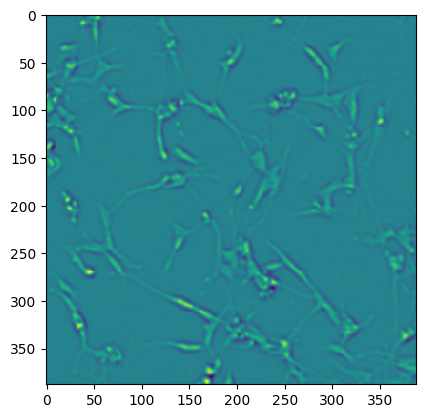

In [49]:
plt.imshow(mask[0,1,:,:], interpolation='nearest')
plt.show()

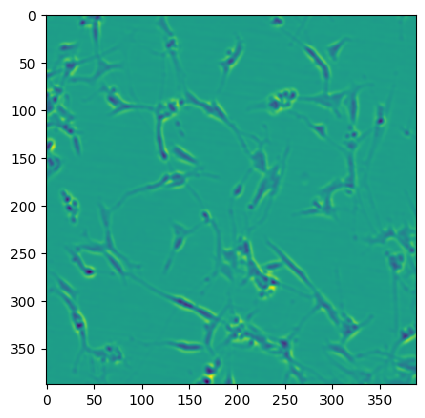

In [50]:
plt.imshow(mask[0,0,:,:], interpolation='nearest')
plt.show()

In [52]:
print(np.max(mask[0,0,:,:]))
print(np.min(mask[0,0,:,:]))

1.1812427
0.8897805
